In [ ]:
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn import utils
from google.colab.patches import cv2_imshow

##Download Dataset From Kaggle

In [ ]:
#Mount your GDrive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload()

#Upload kaggle.json (Kaggle API Token)
#You can download it by create new API Token from your kaggle account

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"auliarasyidrasyid","key":"41edb886e9ccdf9cf283f08739f6dc29"}'}

In [ ]:
#Make sure kaggle.json file is present
!ls -lha kaggle.json

-rw-r--r-- 1 root root 73 May 24 02:39 kaggle.json


In [ ]:
#Install kaggle API client
!pip install -q kaggle

In [ ]:
#Download and unzip the dataset
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download alxmamaev/flowers-recognition
!unzip flowers-recognition.zip

Streaming output truncated to the last 5000 lines.
  inflating: flowers/flowers/rose/110472418_87b6a3aa98_m.jpg  
  inflating: flowers/flowers/rose/11102341464_508d558dfc_n.jpg  
  inflating: flowers/flowers/rose/11233672494_d8bf0a3dbf_n.jpg  
  inflating: flowers/flowers/rose/11694025703_9a906fedc1_n.jpg  
  inflating: flowers/flowers/rose/118974357_0faa23cce9_n.jpg  
  inflating: flowers/flowers/rose/11944957684_2cc806276e.jpg  
  inflating: flowers/flowers/rose/12165480946_c4a3fe182d_n.jpg  
  inflating: flowers/flowers/rose/12202373204_34fb07205b.jpg  
  inflating: flowers/flowers/rose/12238827553_cf427bfd51_n.jpg  
  inflating: flowers/flowers/rose/12240165555_98625b1e88_n.jpg  
  inflating: flowers/flowers/rose/12240303_80d87f77a3_n.jpg  
  inflating: flowers/flowers/rose/12240577184_b0de0e53ea_n.jpg  
  inflating: flowers/flowers/rose/12243068283_ee4c2683e2_n.jpg  
  inflating: flowers/flowers/rose/12243069253_e512464095_n.jpg  
  inflating: flowers/flowers/rose/123128873_546b8b

##1. Tentukan arsitektur MLP

###Ketentuan

* 1 hidden layer
* Jumlah neuron di input layer = jumlah keseluruhan pixel dalam image (320x240)

ARSITEKTUR :


*   Input layer dengan jumlah neuron 320 * 240 = 76800
*   Hidden layer dengan jumlah neuron = 160
* Output layer dengan jumlah neuron 3 ['sunflower', 'daisy', 'dandelion']



##2. Definisikan arsitektur yang digunakan

In [ ]:
input_unit = 76800
hidden_unit = 160
output_unit = 3

##3. Definisikan fungis Load dataset , Visualisasi Data, dan Split data

In [ ]:
directory = r'/content/flowers/'
classes=['sunflower','daisy','dandelion']
def load_split_ds() :

  X_train=[]
  y_train=[]
  X_test=[]
  y_test=[]

  for i,class_name in enumerate(classes):
      path=os.path.join(directory,class_name)
      files=[filename for filename in os.listdir(path) if filename.endswith(".jpg")]
      random.shuffle(files)
      X_train+=files[:80]
      y_train+=([i]*80)
      X_test+=(files[80:100])
      y_test+=([i]*20)
  X_train,y_train=utils.shuffle(X_train,y_train)
  X_test,y_test=utils.shuffle(X_test,y_test)

  return X_train, y_train, X_test, y_test

In [ ]:
X_train, y_train, X_test, y_test = load_split_ds()

for i in range (5) :
    image=cv2.imread(os.path.join(os.path.join(directory,classes[y_train[i]]),X_train[i]))
    image=cv2.resize(image,(240,320))/255.0
   

##4. Definisikan Greyscaling Image

In [ ]:
def grayscale(X,y):
    #print(os.path.join(directory,classes[y]))
    image=cv2.imread(os.path.join(os.path.join(directory,classes[y]),X),cv2.IMREAD_GRAYSCALE)
    image=cv2.resize(image,(240,320))
    return image

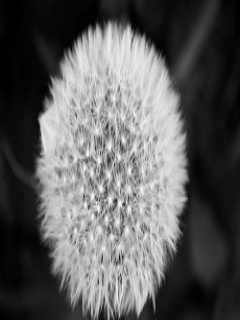

In [ ]:
cv2_imshow(grayscale(X_train[0],y_train[0]))

##5. Definisikan Fungsi Sigmoid

In [ ]:
def sigmoid(x):
    # sigmoid function
    g = 1 / (1 + np.exp(-x))
    return g

##6. Definisikan Backpropagation - Inisialisasi bobot and bias


In [ ]:
def initialization(input_unit,hidden_unit,output_unit):
    W1=np.random.randn(hidden_unit, input_unit)*0.01
    b1 = np.zeros((hidden_unit, 1))
    W2 = np.random.randn(output_unit, hidden_unit)*0.01
    b2 = np.zeros((output_unit, 1))
    parameter = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    return parameter

In [ ]:
#Inisialisasi paramater yang telah kita tentukan
parameter=initialization(input_unit,hidden_unit,output_unit)

##7. Definisikan Backpropagation - menghitung error


In [ ]:
def error(A2,Y):
    """Cross entropy"""
    m=240
    cost=-np.sum(np.multiply(np.log(A2),Y)+np.multiply((1-Y),np.log(1-A2)))/m
    cost=float(np.squeeze(cost))
    return cost

##8. Definisikan Backpropagation - Feedforward


In [ ]:
def feedforward(X,parameter):
    X = X.reshape(input_unit,1)
    Z1 = np.dot(parameter['W1'], X) + parameter['b1']
    A1 = sigmoid(Z1)
    Z2 = np.dot(parameter['W2'], A1) + parameter['b2']
    A2 = sigmoid(Z2)
    return A2, A1

In [ ]:
#testing
A2,A1 =feedforward(grayscale(X_train[0],y_train[0]).flatten(),parameter)
error(A2,y_train[0])
print(A2.shape)

(3, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


##9. Definisikan Backpropagation - Backward (update bobot)

In [ ]:
def update_weight(X, Y, parameter, lrate) :
  output_y, hidden_y = feedforward(X.flatten(),parameter)

  #reshape variable yang diperlukan (Perkalian terbalik)
  output_y = output_y.reshape(1, len(output_y))
  hidden_y = hidden_y.reshape(len(hidden_y), 1)
  X_transpose = X.reshape(len(X), 1)

  #update theta between HIDDEN-OUTPUT layer
  dv_hidden_output = (output_y - Y) * output_y * (1 - output_y)
  dt_hidden_output = np.dot(hidden_y, dv_hidden_output)

  oldparameter = parameter
  parameter['W2'] -= (lrate * dt_hidden_output.T)
  parameter['b2'] -= (lrate * dv_hidden_output[0].reshape(output_unit,1))

  #update theta between INPUT-HIDDEN layer
  dEtotal_hidden_output = np.dot(dv_hidden_output, oldparameter['W2'])
  dv_input_hidden = dEtotal_hidden_output*hidden_y.T * (1 - hidden_y.T)
  dt_input_hidden = np.dot(X_transpose,dv_input_hidden)

  parameter['W1'] -= lrate * dt_input_hidden.T
  parameter['b1'] -= lrate * dt_input_hidden[0].reshape(hidden_unit,1)
  


In [ ]:
#Testing
X = grayscale(X_train[0],y_train[0]).flatten()
update_weight(X, y_train[0], parameter, 0.01)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


##10. Definisikan Backpropagation - prediksi 

In [ ]:
def predict(X,parameter):
  output, _ = feedforward(X, parameter)
  return np.argmax(output)

##11. Definisikan Backpropagation - akurasi 

In [ ]:
def acuracy(parameter):
  count = 0
  for i in range (len(X_test)) :
    img = grayscale(X_test[i], y_test[i])
    if np.argmax(y_test[0]) == predict (img, parameter):
      count += 1
  
  return count/len(X_test)

#BUAT AKURASI SAMA PREDICT
#PARAMETERNYA DIBAWAH
#parameter=initialization(input_unit,hidden_unit,output_unit)

##12. Definisikan fungsi training (80% data) dan testing (20% data)

In [ ]:
def train(parameter, epoch, lrate):
  print("Training model; epoch =", epoch, "; learning_rate =", lrate)
  errors = []
  accuracies = []
  for current_epoch in range(epoch):
    print("EPOCH", current_epoch)
    cur_error = 0
    for i in range(len(X_test)):
      img = grayscale(X_test[i], y_test[i]).flatten()
      output_1,output_2 = feedforward(img, parameter)
      cur_error += error(y_test[i], output_1)
      update_weight(img, y_test[i], parameter, lrate)
    errors.append((cur_error)/len(X_test))
    accuracies.append(acuracy(parameter))
  return errors, accuracies

##13. Visualisasikan error dan akurasi 


In [ ]:
def visualize(errors, accuracies):
  plt.plot(errors, 'r-')
  plt.plot(accuracies, 'b-')
  plt.show()

Training model; epoch = 50 ; learning_rate = 0.1
EPOCH 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


EPOCH 1
EPOCH 2
EPOCH 3
EPOCH 4
EPOCH 5
EPOCH 6
EPOCH 7
EPOCH 8
EPOCH 9
EPOCH 10
EPOCH 11
EPOCH 12
EPOCH 13
EPOCH 14
EPOCH 15
EPOCH 16
EPOCH 17
EPOCH 18
EPOCH 19
EPOCH 20
EPOCH 21
EPOCH 22
EPOCH 23
EPOCH 24
EPOCH 25
EPOCH 26
EPOCH 27
EPOCH 28
EPOCH 29
EPOCH 30
EPOCH 31
EPOCH 32
EPOCH 33
EPOCH 34
EPOCH 35
EPOCH 36
EPOCH 37
EPOCH 38
EPOCH 39
EPOCH 40
EPOCH 41
EPOCH 42
EPOCH 43
EPOCH 44
EPOCH 45
EPOCH 46
EPOCH 47
EPOCH 48
EPOCH 49


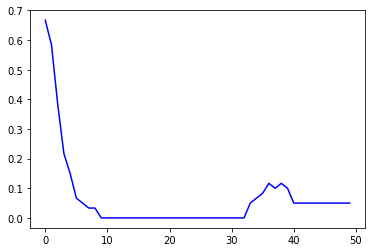

Training model; epoch = 50 ; learning_rate = 0.8
EPOCH 0
EPOCH 1
EPOCH 2
EPOCH 3
EPOCH 4
EPOCH 5
EPOCH 6
EPOCH 7
EPOCH 8
EPOCH 9
EPOCH 10
EPOCH 11
EPOCH 12
EPOCH 13
EPOCH 14
EPOCH 15
EPOCH 16
EPOCH 17
EPOCH 18
EPOCH 19
EPOCH 20
EPOCH 21
EPOCH 22
EPOCH 23
EPOCH 24
EPOCH 25
EPOCH 26
EPOCH 27
EPOCH 28
EPOCH 29
EPOCH 30
EPOCH 31
EPOCH 32
EPOCH 33
EPOCH 34
EPOCH 35
EPOCH 36
EPOCH 37
EPOCH 38
EPOCH 39
EPOCH 40
EPOCH 41
EPOCH 42
EPOCH 43
EPOCH 44
EPOCH 45
EPOCH 46
EPOCH 47
EPOCH 48
EPOCH 49


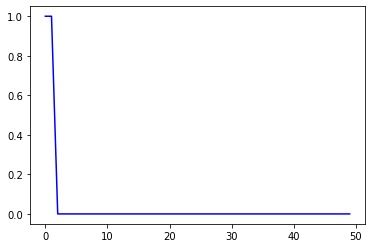

In [ ]:
# percobaan epoch=50 dan learning rate=0,1
errors_0_1, accuracies_0_1 = train(parameter, 50, 0.1)
visualize(errors_0_1, accuracies_0_1)
 
# percobaan epoch=50 dan learning rate=0,8
errors_0_8, accuracies_0_8 = train(parameter, 50, 0.8)
visualize(errors_0_8, accuracies_0_8)